In [2]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torch
import json

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:

def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(700, 700), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=2, max_h_size=32, max_w_size=32, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),

        ], p = 1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
            
        )
    )
    
def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )


In [4]:
STAGE_PATH = "/home/ubuntu/data/sumaDetData/DetStage"
ANNO_PATH = "/home/ubuntu/data/sumaDetData/export-2021-01-20T11_25_42.944Z.json"
CLASSES = ["gake"]

class DatasetRetriever(Dataset):

    def __init__(self, transforms=None, valid=False):
        super().__init__()
        self.transforms = transforms
        self.valid = valid
        self.stage_names, self.box_and_label = self.load_annotation()
        
    def __getitem__(self, index: int):
        stage_name = self.stage_names[index]
        image = self.load_image(index)
        
        target = {}
        target['boxes'] = self.box_and_label[stage_name]["boxes"]
        target['labels'] = torch.tensor(self.box_and_label[stage_name]["labels"])
        target['image_id'] = torch.tensor([index])
        
        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': target["labels"],
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, index
    
    def __len__(self) -> int:
        return len(self.stage_name)
    
    def load_annotation(self):
        with open(ANNO_PATH, "rb") as f:
            anno = json.load(f)
        stage_names = []
        boxes_and_labels = {}
        for i in anno:
            stage_name = i["External ID"]
            stage_names.append(stage_name)
            b = []
            l = []
            for x in i["Label"]["objects"]:
                boxes = x["bbox"]
                boxes = [i for i in boxes.values()]
                b.append(self.xywh2xyxy(boxes))
                l.append(CLASSES.index(x["value"]) + 1)
            boxes_and_labels[stage_name] = {"boxes":b, "labels":l}
        return stage_names, boxes_and_labels

    def load_image(self, index):
        stage_name = self.stage_names[index]
        image = cv2.imread(f'{STAGE_PATH}/{stage_name}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        return image
    
    def xywh2xyxy(self, box):
        min_y, min_x, height, width = box
        x1, y1, x2, y2 = min_x, min_y, min_x + width, min_y + height
        return [x1, y1, x2, y2]

In [6]:

train_dataset = DatasetRetriever(
    transforms=get_train_transforms(),
    valid=False,
)

validation_dataset = DatasetRetriever(
    transforms=get_valid_transforms(),
    valid=True,
)

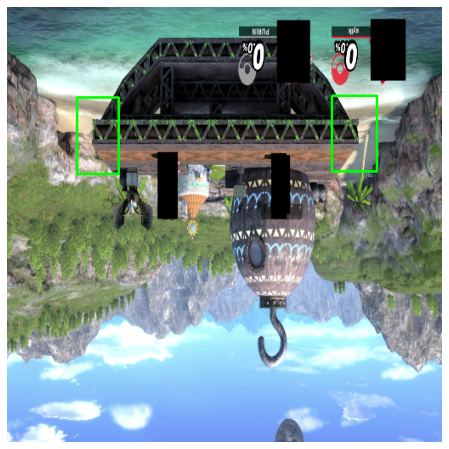

In [7]:
image, target, image_id = validation_dataset[0]
image, target, image_id = train_dataset[0]

boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image)
plt.show()

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5
        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss, mean_AP = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)
            for c in classes:
                print(c, mean_AP[c])
            

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        det_boxes = []
        det_scores = []
        det_labels = []
        true_boxes = []
        true_labels = []
        true_difficulties = []
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                target_res = {}
                target_res['bbox'] = boxes
                target_res['cls'] = labels 
                target_res["img_scale"] = torch.tensor([1.0] * batch_size, dtype=torch.float).to(self.device)
                target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float).to(self.device)

                outputs = self.model(images, target_res)
                loss = outputs["loss"]
                summary_loss.update(loss.detach().item(), batch_size)
                for i in range(batch_size):
                    det_boxes.append(outputs["detections"][i,:10,:4])
                    det_scores.append(outputs["detections"][i,:10,4])
                    det_labels.append(outputs["detections"][i,:10,5])
                    true_boxes.append(boxes[i][:,[1,0,3,2]])
                    true_labels.append(labels[i])
                    true_difficulties.append(torch.tensor([0] * len(labels[i])))
  
                                        
        mean_AP = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties)
        return summary_loss, mean_AP[0]

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            break
            
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )


            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]
            
            self.optimizer.zero_grad()

            output = self.model(images, {"bbox":boxes, "cls":labels})
            loss = output["loss"]
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [ ]:
class TrainGlobalConfig:
    num_workers = 2
    batch_size = 1
    n_epochs = 40 # n_epochs = 40
    lr = 0.0002

    folder = 'effdet5-cutmix-augmix'
    #folder = 'effdet5-cutmix-augmix-xyxy'


    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    #fitter.load("effdet5-cutmix-augmix/last-checkpoint.bin")
    #itter.load("effdet5-cutmix-augmix/best-checkpoint-014epoch.bin")
    fitter.fit(train_loader, val_loader)

In [ ]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def get_net():
    config = get_efficientdet_config('tf_efficientdet_d5')
    config.num_classes = 2
    config.image_size = (512,512)

    net = EfficientDet(config, pretrained_backbone=False)
    #checkpoint = torch.load("effdet5-cutmix-augmix/best-checkpoint-002epoch.bin")
    #net.load_state_dict(checkpoint['model_state_dict'])
    #checkpoint = torch.load('../input/efficientdet/efficientdet_d5-ef44aea8.pth')

    net.reset_head(num_classes=2)

    net.class_net = HeadNet(config, num_outputs=2)
    return DetBenchTrain(net, config)

net = get_net()
#net = nn.DataParallel(net)

In [ ]:
run_training()
